<h1 align = "center"> Time-constrained Tourists + Immigrants Problems </h1>
<h3 align = "center"> Providing a City Guide for Foreigners for any purpose </h3>

Shun-Ping (Preston) Yu <br><br>
16th July 2021

## Introduction

There are lots of foreign and local people in a city. Especially for foreign visiters, they come to a city for many purposes, such as business, travelling, immigration and so on. In this capstone project, we will take the Big Apple, New York City, as example to demonstrate how to solve foreign visiters' common problems.  

## Business Problem

Imagine your are running a tourist agency company which is in capable of not only helping immigrants find suitable residential place to settle down, but also planning tourist packages for every customers. The aim is to satisfy all your customers for any purpose. One day, you get 2 different cases from different customers. <br> 
<li> Customer A - An immigrant from Taiwan : Searching for suitable area to live in </li>
<li> Customer B - A group of tourists : Visiting as many top attractions as possible in 3 days (because they will move on to the next city in the 4th day) </li>

## Data Description

<h4> Geolocation data for New York City </h4>
I reused the data from the previous lab (https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json) and extract the following information.<br>
* 1. Borough <br>
* 2. Neighborhood <br>	
* 3. Latitude	<br>
* 4. Longitude <br>

<h4> NYC Property Sales </h4>
I used the data from kaggle (https://www.kaggle.com/new-york-city/nyc-property-sales) and extract the following information.<br>
* 1. Neighborhood <br>	
* 2. Sale Price	<br>
This dataset is a record of every building or building unit (apartment, etc.) sold in the New York City property market over a 12-month period.

<h4> Google OR-Tools Traveling Salesperson Problem (TSP) </h4>
I used the open-source routing package from Google OR-Tools.(https://developers.google.com/optimization/routing/tsp) <br>
TSP is used for finding the shortest route for a salesperson who needs to visit customers at different locations and return to the starting point. A TSP can be represented by a graph, in which the nodes correspond to the locations, and the edges (or arcs) denote direct travel between locations.

## Methodology

We will be creating our model with the help of Python so we start off by importing all the required packages, so let's download all the dependencies that we will need.

In [55]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

!pip install ortools
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

The approach taken here is to explore the city, plot the map to show the neighbourhoods being considered and then build our model by clustering all of the similar neighbourhoods or nearby top attractions together, and finally plot the new map with the clustered results. We draw insights and then compare and discuss our findings.

--------------------------------------------------------------------------------------------------------------------------------------------------------

## Part A.   Immigrants Problem - Searching for suitable area to live in

We begin to start collecting and refining the data needed for the our business solution to work.

### 1) Data Collection - Download and Explore Dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


**1.1) Load and explore the data**

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

**1.2) Arrange Neighborhood JSON file to DataFrame Format**

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


**1.3) Use geopy library to get the latitude and longitude values of New York City.**

In [7]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


**1.4) Create a map of New York with neighborhoods superimposed on top.**

In [8]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**1.5) Define Foursquare Credentials and Version**

Using Foursquare API, we are able to get the venue and venue categories around each neighbourhood in New York City

In [9]:
CLIENT_ID = 'FOP4YBIEWZ5G4MN5CPVLIWCDQ0HXESG5TWMDQJUREZRE12YC' # your Foursquare ID
CLIENT_SECRET = 'DGMSCBDBOEGO4S3K5I3P4NYECUE1QYR5OFFUQJB0JBL2OWZO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FOP4YBIEWZ5G4MN5CPVLIWCDQ0HXESG5TWMDQJUREZRE12YC
CLIENT_SECRET:DGMSCBDBOEGO4S3K5I3P4NYECUE1QYR5OFFUQJB0JBL2OWZO


**1.6) Get Nearby Venues in the Neighborhood**

Defining a function to get the neraby venues in the neighbourhood. This will help us get venue categories which is important for our analysis

In [10]:
LIMIT = 10000
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
# Getting the venues in New York City
nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

### 2) Data Processing - Data Cleaning and Wrangling + Exploratory Data Analysis + Feature Engineering

In [12]:
print(nyc_venues.shape)
nyc_venues.head()

(30531, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                      Venue  Venue Latitude  Venue Longitude  \
0          Lollipops Gelato       40.894123       -73.845892   
1           Ali's Roti Shop       40.894036       -73.856935   
2        Ripe Kitchen & Bar       40.898152       -73.838875   
3  Kingston Tropical Bakery       40.888568       -73.859885   
4                   Jimbo's       40.891740       -73.858226   

         Venue Category  
0          Dessert Shop  
1  Caribbean Restaurant  
2  Caribbean Restaurant  
3                Bakery  
4          Burger Joint

**2.1) Define the Nearest Neighborhood for each Venue**

Calculate the distance (in meter) between venues and neighborhoods

In [13]:
import math
nyc_venues['distance_to_neighborhood_meters'] = 0
for i in range(0,len(nyc_venues)):
    nyc_venues['distance_to_neighborhood_meters'][i] = round(math.sqrt((nyc_venues['Venue Latitude'][i] - nyc_venues['Neighborhood Latitude'][i])**2 + (nyc_venues['Venue Longitude'][i] - nyc_venues['Neighborhood Longitude'][i])**2) * 111320,2)
    
nyc_venues.head()    

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                      Venue  Venue Latitude  Venue Longitude  \
0          Lollipops Gelato       40.894123       -73.845892   
1           Ali's Roti Shop       40.894036       -73.856935   
2        Ripe Kitchen & Bar       40.898152       -73.838875   
3  Kingston Tropical Bakery       40.888568       -73.859885   
4                   Jimbo's       40.891740       -73.858226   

         Venue Category  distance_to_neighborhood_meters  
0          Dessert Shop                              159  
1  Caribbean Restaurant                             1086  
2  Caribbean Restaurant                             1003  
3                Bakery                             1568  
4          Burger Joint                             1270

Display only the nearest neighborhood for each venue and exclude all the other non-nearest ones

In [14]:
unique_venue = nyc_venues[['Venue','Venue Latitude','Venue Longitude','Venue Category']].drop_duplicates()
unique_venue = unique_venue.reset_index(drop = True)
min_distance_to_neighborhood_per_venue = {}

for i in range(0,len(unique_venue)):
    min_distance_to_neighborhood_per_venue[i] = min(nyc_venues[nyc_venues['Venue'] == unique_venue['Venue'][i]]['distance_to_neighborhood_meters'])
    
min_distance_to_neighborhood_per_venue_df = pd.DataFrame.from_dict(min_distance_to_neighborhood_per_venue, orient='index') 
unique_venue2 = pd.concat([unique_venue,min_distance_to_neighborhood_per_venue_df], axis = 1)

nyc_venues_neighborhood = nyc_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','distance_to_neighborhood_meters','Venue']]
nyc_venues_df = unique_venue2.merge(nyc_venues_neighborhood, left_on = [0,'Venue'], right_on = ['distance_to_neighborhood_meters','Venue'], how = 'inner')
nyc_venues_df = nyc_venues_df.drop([0], axis = 1)
nyc_venues_df.head()

Venue  Venue Latitude  Venue Longitude  \
0          Lollipops Gelato       40.894123       -73.845892   
1           Ali's Roti Shop       40.894036       -73.856935   
2           Ali's Roti Shop       40.666436       -73.931346   
3        Ripe Kitchen & Bar       40.898152       -73.838875   
4  Kingston Tropical Bakery       40.888568       -73.859885   

         Venue Category    Neighborhood  Neighborhood Latitude  \
0          Dessert Shop       Wakefield              40.894705   
1  Caribbean Restaurant       Wakefield              40.894705   
2  Caribbean Restaurant       Wakefield              40.894705   
3  Caribbean Restaurant       Wakefield              40.894705   
4                Bakery  Williamsbridge              40.881039   

   Neighborhood Longitude  distance_to_neighborhood_meters  
0              -73.847201                              159  
1              -73.847201                             1086  
2              -73.847201                             1086  
3              -73.847201                             1003  
4              -73.857446                              881

**2.2) Import House Sale Price Data + Data Cleaning**

In [15]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_93d163___________54ee = 'https://s3.ap.cloud-object-storage.appdomain.cloud'
else:
    endpoint_93d163___________54ee = 'https://s3.private.ap.cloud-object-storage.appdomain.cloud'

client_93d163___________54ee = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='***********************************',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_93d163___________54ee)

body = client_93d163___________54ee.get_object(Bucket='capstoneproject-donotdelete-pr-qf3fzlx0qx4qet',Key='nyc-rolling-sales.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

Unnamed: 0  BOROUGH   NEIGHBORHOOD  \
0           4        1  ALPHABET CITY   
1           5        1  ALPHABET CITY   
2           6        1  ALPHABET CITY   
3           7        1  ALPHABET CITY   
4           8        1  ALPHABET CITY   

                       BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  \
0  07 RENTALS - WALKUP APARTMENTS                                2A    392   
1  07 RENTALS - WALKUP APARTMENTS                                 2    399   
2  07 RENTALS - WALKUP APARTMENTS                                 2    399   
3  07 RENTALS - WALKUP APARTMENTS                                2B    402   
4  07 RENTALS - WALKUP APARTMENTS                                2A    404   

   LOT EASE-MENT BUILDING CLASS AT PRESENT                 ADDRESS  \
0    6                                  C2            153 AVENUE B   
1   26                                  C7   234 EAST 4TH   STREET   
2   39                                  C7   197 EAST 3RD   STREET   
3   21                                  C4     154 EAST 7TH STREET   
4   55                                  C2  301 EAST 10TH   STREET   

  APARTMENT NUMBER  ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  \
0                      10009                  5                 0   
1                      10009                 28                 3   
2                      10009                 16                 1   
3                      10009                 10                 0   
4                      10009                  6                 0   

   TOTAL UNITS LAND SQUARE FEET GROSS SQUARE FEET  YEAR BUILT  \
0            5             1633              6440        1900   
1           31             4616             18690        1900   
2           17             2212              7803        1900   
3           10             2272              6794        1913   
4            6             2369              4615        1900   

   TAX CLASS AT TIME OF SALE BUILDING CLASS AT TIME OF SALE SALE PRICE  \
0                          2                             C2    6625000   
1                          2                             C7        -     
2                          2                             C7        -     
3                          2                             C4    3936272   
4                          2                             C2    8000000   

             SALE DATE  
0  2017-07-19 00:00:00  
1  2016-12-14 00:00:00  
2  2016-12-09 00:00:00  
3  2016-09-23 00:00:00  
4  2016-11-17 00:00:00

In [16]:
df_data_1 = df_data_1.replace('UPPER EAST SIDE (59-79)', 'UPPER EAST SIDE')
df_data_1 = df_data_1.replace('UPPER EAST SIDE (79-96)', 'UPPER EAST SIDE')
df_data_1 = df_data_1.replace('UPPER EAST SIDE (96-110)', 'UPPER EAST SIDE')
df_data_1 = df_data_1.replace('UPPER WEST SIDE (59-79)', 'UPPER WEST SIDE')
df_data_1 = df_data_1.replace('UPPER WEST SIDE (79-96)', 'UPPER WEST SIDE')
df_data_1 = df_data_1.replace('UPPER WEST SIDE (96-116)', 'UPPER WEST SIDE')
df_data_1 = df_data_1.replace('HARLEM-UPPER', 'EAST HARLEM')
df_data_1 = df_data_1.replace('HARLEM-WEST', 'CENTRAL HARLEM')
df_data_1 = df_data_1.replace('HARLEM-EAST', 'EAST HARLEM')
df_data_1 = df_data_1.replace('HARLEM-CENTRAL', 'CENTRAL HARLEM')
df_data_1 = df_data_1.replace('GREENWICH VILLAGE-WEST', 'GREENWICH VILLAGE')
df_data_1 = df_data_1.replace('GREENWICH VILLAGE-CENTRAL', 'GREENWICH VILLAGE')
df_data_1 = df_data_1.replace('FINANCIAL', 'FINANCIAL DISTRICT')
df_data_1 = df_data_1.replace('MIDTOWN CBD', 'MIDTOWN SOUTH')
df_data_1 = df_data_1.replace('MIDTOWN EAST', 'MIDTOWN')
df_data_1 = df_data_1.replace('MIDTOWN WEST', 'MIDTOWN')
df_data_1 = df_data_1.replace('WASHINGTON HEIGHTS LOWER', 'WASHINGTON HEIGHTS')
df_data_1 = df_data_1.replace('WASHINGTON HEIGHTS UPPER', 'WASHINGTON HEIGHTS')
df_data_1 = df_data_1.replace('CITY ISLAND-PELHAM STRIP', 'CITY ISLAND')
df_data_1 = df_data_1.replace('COBBLE HILL-WEST', 'COBBLE HILL')
df_data_1 = df_data_1.replace('DOWNTOWN-FULTON FERRY', 'DOWNTOWN')
df_data_1 = df_data_1.replace('DOWNTOWN-FULTON MALL', 'DOWNTOWN')
df_data_1 = df_data_1.replace('DOWNTOWN-METROTECH', 'DOWNTOWN')
df_data_1 = df_data_1.replace('FLATBUSH-CENTRAL', 'FLATBUSH')
df_data_1 = df_data_1.replace('FLATBUSH-LEFFERTS GARDEN', 'Prospect Lefferts Gardens')
df_data_1 = df_data_1.replace('FLATBUSH-NORTH', 'FLATBUSH')
df_data_1 = df_data_1.replace('FLATBUSH-EAST', 'EAST FLATBUSH')
df_data_1 = df_data_1.replace('OCEAN PARKWAY-NORTH', 'OCEAN PARKWAY')
df_data_1 = df_data_1.replace('OCEAN PARKWAY-SOUTH', 'OCEAN PARKWAY')
df_data_1 = df_data_1.replace('WILLIAMSBURG-CENTRAL', 'WILLIAMSBURG')
df_data_1 = df_data_1.replace('WILLIAMSBURG-SOUTH', 'WILLIAMSBURG')
df_data_1 = df_data_1.replace('WILLIAMSBURG-NORTH', 'WILLIAMSBURG')
df_data_1 = df_data_1.replace('FLATBUSH-EAST', 'EAST WILLIAMSBURG')
df_data_1 = df_data_1.replace('FLUSHING MEADOW PARK', 'FLUSHING')
df_data_1 = df_data_1.replace('FLUSHING-NORTH', 'FLUSHING')
df_data_1 = df_data_1.replace('FLUSHING-SOUTH', 'FLUSHING')
df_data_1 = df_data_1.replace('CONCORD-FOX HILLS', 'FOX HILLS')
df_data_1 = df_data_1.replace('DONGAN HILLS-COLONY', 'DONGAN HILLS')
df_data_1 = df_data_1.replace('DONGAN HILLS-OLD TOWN', 'OLD TOWN')
df_data_1 = df_data_1.replace('GREAT KILLS-BAY TERRACE', 'BAY TERRACE')
df_data_1 = df_data_1.replace('NEW BRIGHTON-ST. GEORGE', 'NEW BRIGHTON')
df_data_1 = df_data_1.replace('WEST NEW BRIGHTON', 'NEW BRIGHTON')
df_data_1 = df_data_1.replace('NEW DORP-BEACH', 'NEW DORP BEACH')
df_data_1 = df_data_1.replace('NEW DORP-HEIGHTS', 'NEW DORP')
df_data_1 = df_data_1.replace('OAKWOOD-BEACH', 'OAKWOOD')
df_data_1 = df_data_1.replace('ROSSVILLE-CHARLESTON', 'CHARLESTON')
df_data_1 = df_data_1.replace('ROSSVILLE-PORT MOBIL', 'ROSSVILLE')
df_data_1 = df_data_1.replace('ROSSVILLE-RICHMOND VALLEY', 'RICHMOND VALLEY')
df_data_1 = df_data_1.replace('STAPLETON-CLIFTON', 'CLIFTON')
df_data_1 = df_data_1.replace('KINGSBRIDGE HTS/UNIV HTS', 'KINGSBRIDGE HEIGHTS/UNIVERSITY HEIGHTS')

bb = df_data_1[df_data_1['NEIGHBORHOOD'].isin(['BEDFORD PARK/NORWOOD','CASTLE HILL/UNIONPORT','HIGHBRIDGE/MORRIS HEIGHTS','KINGSBRIDGE HEIGHTS/UNIVERSITY HEIGHTS','KINGSBRIDGE/JEROME PARK', 'MELROSE/CONCOURSE', \
       'MORRIS PARK/VAN NEST', 'MORRISANIA/LONGWOOD','MOTT HAVEN/PORT MORRIS','MOUNT HOPE/MOUNT EDEN','SCHUYLERVILLE/PELHAM BAY'])]
cc = bb
aa = df_data_1[~df_data_1['NEIGHBORHOOD'].isin(['BEDFORD PARK/NORWOOD','CASTLE HILL/UNIONPORT','HIGHBRIDGE/MORRIS HEIGHTS','KINGSBRIDGE HEIGHTS/UNIVERSITY HEIGHTS','KINGSBRIDGE/JEROME PARK', 'MELROSE/CONCOURSE', \
       'MORRIS PARK/VAN NEST', 'MORRISANIA/LONGWOOD','MOTT HAVEN/PORT MORRIS','MOUNT HOPE/MOUNT EDEN','SCHUYLERVILLE/PELHAM BAY'])]

bb = bb.replace('BEDFORD PARK/NORWOOD','BEDFORD PARK')
bb = bb.replace('CASTLE HILL/UNIONPORT','CASTLE HILL')
bb = bb.replace('HIGHBRIDGE/MORRIS HEIGHTS','HIGHBRIDGE')
bb = bb.replace('KINGSBRIDGE HEIGHTS/UNIVERSITY HEIGHTS','KINGSBRIDGE HEIGHTS')
bb = bb.replace('KINGSBRIDGE/JEROME PARK','KINGSBRIDGE')
bb = bb.replace('MELROSE/CONCOURSE','MELROSE')
bb = bb.replace('MORRIS PARK/VAN NEST','MORRIS PARK')
bb = bb.replace('MORRISANIA/LONGWOOD','MORRISANIA')
bb = bb.replace('MOTT HAVEN/PORT MORRIS','MOTT HAVEN')
bb = bb.replace('MOUNT HOPE/MOUNT EDEN','MOUNT HOPE')
bb = bb.replace('SCHUYLERVILLE/PELHAM BAY','SCHUYLERVILLE')

cc = cc.replace('BEDFORD PARK/NORWOOD','NORWOOD')
cc = cc.replace('CASTLE HILL/UNIONPORT','UNIONPORT')
cc = cc.replace('HIGHBRIDGE/MORRIS HEIGHTS','MORRIS HEIGHTS')
cc = cc.replace('KINGSBRIDGE HEIGHTS/UNIVERSITY HEIGHTS','UNIVERSITY HEIGHTS')
cc = cc.replace('KINGSBRIDGE/JEROME PARK','JEROME PARK')
cc = cc.replace('MELROSE/CONCOURSE','CONCOURSE')
cc = cc.replace('MORRIS PARK/VAN NEST','VAN NEST')
cc = cc.replace('MORRISANIA/LONGWOOD','LONGWOOD')
cc = cc.replace('MOTT HAVEN/PORT MORRIS','PORT MORRIS')
cc = cc.replace('MOUNT HOPE/MOUNT EDEN','MOUNT EDEN')
cc = cc.replace('SCHUYLERVILLE/PELHAM BAY','PELHAM BAY')

aa = aa.reset_index(drop = True)
bb = bb.reset_index(drop = True)
cc = cc.reset_index(drop = True)

df_data = pd.concat([aa,bb,cc], axis = 0)
df_data = df_data.reset_index(drop = True)
df_data = df_data[df_data['SALE PRICE'] != ' -  ']
df_data = df_data.reset_index(drop = True)
df_data['SALE PRICE'] = df_data['SALE PRICE'].astype('int64')
df_data = df_data[['NEIGHBORHOOD','SALE PRICE']]
df_data_grouped = df_data.groupby('NEIGHBORHOOD').mean().reset_index()
df_data_grouped.head()

NEIGHBORHOOD    SALE PRICE
0  AIRPORT LA GUARDIA  5.987871e+05
1       ALPHABET CITY  2.600241e+06
2            ANNADALE  6.280466e+05
3       ARDEN HEIGHTS  3.949565e+05
4            ARROCHAR  5.700459e+05

**2.3) Define the Composition of Neighborhoods**

Using one hot encoding to encode venue categories to get a better result for our upcoming clustering steps

In [17]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues_df[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot = nyc_onehot.drop(['Neighborhood'], axis = 1)

# add neighborhood column back to dataframe
nyc_onehot['_Neighborhood'] = nyc_venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

a = list(nyc_onehot.columns)
a[0] = 'Neighborhood'
nyc_onehot.columns = a

nyc_onehot.head()

Neighborhood  Accessories Store  African Restaurant  Airport Food Court  \
0       Wakefield                  0                   0                   0   
1       Wakefield                  0                   0                   0   
2       Wakefield                  0                   0                   0   
3       Wakefield                  0                   0                   0   
4  Williamsbridge                  0                   0                   0   

   Airport Lounge  Airport Service  American Restaurant  Animal Shelter  \
0               0                0                    0               0   
1               0                0                    0               0   
2               0                0                    0               0   
3               0                0                    0               0   
4               0                0                    0               0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0       0                 0                       0            0   
1         0       0                 0                       0            0   
2         0       0                 0                       0            0   
3         0       0                 0                       0            0   
4         0       0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Austrian Restaurant  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  \
0                    0                0          0           0       0     0   
1                    0                0          0           0       0     0   
2                    0                0          0           0       0     0   
3                    0                0          0           0       0     0   
4                    0                0          0           0       1     0   

   Bar  Baseball Field  Baseball Stadium  Basketball Court  Beach  Beach Bar  \
0    0               0                 0                 0      0          0   
1    0               0                 0                 0      0          0   
2    0               0                 0                 0      0          0   
3    0               0                 0                 0      0          0   
4    0               0                 0                 0      0          0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Shop  Bike Trail  \
0         0            0           0              0          0           0   
1         0            0           0              0          0           0   
2         0            0           0              0          0           0   
3         0            0           0              0          0           0   
4         0            0           0              0          0           0   

   Bistro  Board Shop  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0       0           0              0          0                 0         0   
1       0           0              0          0                 0         0   
2       0           0              0          0                 0         0   
3       0           0              0          0                 0         0   
4       0           0              0          0                 0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               0        0   
1              0           0                     0               0        0   
2   

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [18]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped

Neighborhood  Accessories Store  African Restaurant  \
0                     Allerton           0.000000            0.000000   
1                     Annadale           0.000000            0.000000   
2                Arden Heights           0.000000            0.000000   
3                    Arlington           0.000000            0.000000   
4                     Arrochar           0.000000            0.000000   
5                      Arverne           0.000000            0.000000   
6                      Astoria           0.000000            0.000000   
7              Astoria Heights           0.000000            0.000000   
8                   Auburndale           0.000000            0.000000   
9                   Bath Beach           0.000000            0.000000   
10           Battery Park City           0.000000            0.000000   
11                   Bay Ridge           0.000000            0.000000   
12                 Bay Terrace           0.000000            0.000000   
13                  Baychester           0.000000            0.000000   
14                     Bayside           0.000000            0.000000   
15                   Bayswater           0.000000            0.000000   
16                Bedford Park           0.000000            0.000000   
17          Bedford Stuyvesant           0.000000            0.000000   
18                  Beechhurst           0.000000            0.000000   
19                    Bellaire           0.000000            0.000000   
20                Belle Harbor           0.000000            0.000000   
21                   Bellerose           0.000000            0.000000   
22                     Belmont           0.000000            0.000000   
23                 Bensonhurst           0.000000            0.000000   
24                Bergen Beach           0.000000            0.000000   
25                  Blissville           0.000000            0.000000   
26                  Bloomfield           0.000000            0.000000   
27                 Boerum Hill           0.000000            0.000000   
28                Borough Park           0.000000            0.000000   
29                Breezy Point           0.000000            0.000000   
30                   Briarwood           0.000000            0.000000   
31              Brighton Beach           0.000000            0.000000   
32               Broad Channel           0.000000            0.000000   
33           Broadway Junction           0.000000            0.000000   
34                   Bronxdale           0.000000            0.000000   
35            Brooklyn Heights           0.000000            0.000000   
36                  Brookville           0.000000            0.000000   
37                 Brownsville           0.000000            0.125000   
38                  Bulls Head           0.000000            0.000000   
39                    Bushwick           0.000000            0.000000   
40                Butler Manor           0.000000            0.000000   
41             Cambria Heights           0.000000            0.000000   
42                    Canarsie           0.000000            0.000000   
43               Carnegie Hill           0.000000            0.000000   
44             Carroll Gardens           0.000000            0.000000   
45                 Castle Hill           0.000000            0.000000   
46           Castleton Corners           0.000000            0.000000   
47              Central Harlem           0.000000            0.000000   
48                  Charleston           0.000000            0.000000   
49                     Chelsea           0.000000            0.000000   
50                   Chinatown           0.000000            0.000000   
51                 City Island           0.000000            0.000000   
52                   City Line           0.000000            0.000000   
53                Civic Center           0.000000            0.000000   
54 

Print each neighborhood along with the top 5 most common venues

In [19]:
num_top_venues = 5

for hood in nyc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
               venue  freq
0        Pizza Place   0.4
1            Brewery   0.2
2       Dessert Shop   0.2
3              Diner   0.2
4  Other Repair Shop   0.0


----Annadale----
             venue  freq
0  Supplement Shop  0.17
1     Burger Joint  0.08
2      Pizza Place  0.08
3     Skating Rink  0.08
4       Bagel Shop  0.08


----Arden Heights----
              venue  freq
0  Sushi Restaurant   1.0
1       Pizza Place   0.0
2    Pilates Studio   0.0
3              Pier   0.0
4          Pie Shop   0.0


----Arlington----
                venue  freq
0    Department Store  0.75
1  Spanish Restaurant  0.25
2  Persian Restaurant  0.00
3      Pilates Studio  0.00
4                Pier  0.00


----Arrochar----
                   venue  freq
0                  Beach   0.4
1  Outdoors & Recreation   0.2
2                    Gym   0.2
3            Pizza Place   0.2
4      Accessories Store   0.0


----Arverne----
         venue  freq
0    Surf Spot   0.4
1   Skate Park   0.

                 venue  freq
0          Pizza Place  0.17
1  Japanese Restaurant  0.17
2       Hardware Store  0.17
3            Wine Shop  0.17
4          Golf Course  0.17


----Castleton Corners----
          venue  freq
0   Pizza Place  0.38
1  Dessert Shop  0.12
2         Diner  0.12
3  Optical Shop  0.12
4   Beer Garden  0.12


----Central Harlem----
                             venue  freq
0  Southern / Soul Food Restaurant  0.17
1                      Pizza Place  0.11
2                     Cycle Studio  0.06
3                          Library  0.06
4                      Coffee Shop  0.06


----Charleston----
                 venue  freq
0        Big Box Store  0.21
1       Cosmetics Shop  0.12
2  Arts & Crafts Store  0.12
3          Pizza Place  0.07
4               Bakery  0.07


----Chelsea----
            venue  freq
0  Clothing Store  0.12
1            Park  0.12
2      Taco Place  0.12
3     Art Gallery  0.08
4  Sandwich Place  0.04


----Chinatown----
                 v



----Flatlands----
                  venue  freq
0            Donut Shop  0.27
1  Caribbean Restaurant  0.18
2   Sporting Goods Shop  0.18
3        Ice Cream Shop  0.09
4           Flower Shop  0.09


----Floral Park----
               venue  freq
0        Pizza Place  0.13
1      Deli / Bodega  0.06
2  Indian Restaurant  0.06
3              Diner  0.06
4             Bakery  0.04


----Flushing----
                 venue  freq
0   Chinese Restaurant  0.15
1               Bakery  0.11
2      Bubble Tea Shop  0.09
3  Dumpling Restaurant  0.09
4    Hotpot Restaurant  0.09


----Fordham----
                       venue  freq
0                      Diner   0.2
1         Mexican Restaurant   0.2
2  Latin American Restaurant   0.2
3                       Café   0.2
4             History Museum   0.2


----Forest Hills----
                venue  freq
0           Gastropub  0.08
1          Boxing Gym  0.08
2  Mexican Restaurant  0.08
3          Bagel Shop  0.08
4     Thai Restaurant  0.08


--

               venue  freq
0  Electronics Store  0.33
1        High School  0.17
2        Pizza Place  0.17
3      Historic Site  0.17
4     Ice Cream Shop  0.17


----Kingsbridge----
                venue  freq
0        Burger Joint  0.17
1  Mexican Restaurant  0.09
2         Supermarket  0.09
3                 Bar  0.09
4         Pizza Place  0.09


----Laurelton----
                  venue  freq
0  Caribbean Restaurant  0.50
1           Pizza Place  0.25
2                  Park  0.25
3    Persian Restaurant  0.00
4        Pilates Studio  0.00


----Lefrak City----
                      venue  freq
0          Toy / Game Store  0.12
1  Mediterranean Restaurant  0.12
2        Chinese Restaurant  0.12
3              Liquor Store  0.06
4           Thai Restaurant  0.06


----Lenox Hill----
              venue  freq
0               Gym  0.11
1             Hotel  0.11
2            Resort  0.06
3  Sculpture Garden  0.06
4      Cocktail Bar  0.06


----Lighthouse Hill----
                ven

                  venue  freq
0           Pizza Place   0.4
1    Italian Restaurant   0.2
2            Smoke Shop   0.2
3  Gym / Fitness Center   0.2
4     Accessories Store   0.0


----Oakland Gardens----
                venue  freq
0   Korean Restaurant  0.19
1         Pizza Place  0.14
2         Yoga Studio  0.10
3  Italian Restaurant  0.10
4               Diner  0.05


----Oakwood----
                   venue  freq
0                   Park   0.5
1     Italian Restaurant   0.5
2  Performing Arts Venue   0.0
3         Pilates Studio   0.0
4                   Pier   0.0


----Ocean Hill----
         venue  freq
0          Bar  0.31
1       Bakery  0.12
2         Café  0.06
3         Park  0.06
4  Coffee Shop  0.06


----Ocean Parkway----
                venue  freq
0  Italian Restaurant  0.22
1        Burger Joint  0.11
2                Café  0.11
3       Deli / Bodega  0.11
4                 Bar  0.11


----Old Town----
                   venue  freq
0                 Bakery   0.5
1 



----Soundview----
                   venue  freq
0                   Park  0.33
1    American Restaurant  0.33
2          Grocery Store  0.33
3  Performing Arts Venue  0.00
4         Pilates Studio  0.00


----South Beach----
                venue  freq
0  Italian Restaurant  0.36
1               Beach  0.14
2  Athletics & Sports  0.07
3                Pier  0.07
4                 Bar  0.07


----South Jamaica----
                           venue  freq
0                 Clothing Store  0.13
1                      BBQ Joint  0.07
2  Vegetarian / Vegan Restaurant  0.07
3             Mexican Restaurant  0.07
4              Indian Restaurant  0.07


----South Ozone Park----
                  venue  freq
0  Caribbean Restaurant  0.12
1        Airport Lounge  0.12
2   Rental Car Location  0.12
3           Pizza Place  0.12
4            Restaurant  0.06


----South Side----
               venue  freq
0   Toy / Game Store  0.25
1       Gourmet Shop  0.25
2         Comic Shop  0.25
3        P

Create a new dataframe and display the top 20 venues for each neighborhood

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
0       Allerton           Pizza Place                Brewery   
1       Annadale       Supplement Shop           Burger Joint   
2  Arden Heights      Sushi Restaurant            Pizza Place   
3      Arlington      Department Store     Spanish Restaurant   
4       Arrochar                 Beach  Outdoors & Recreation   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Dessert Shop                 Diner     Other Repair Shop   
1           Pizza Place          Skating Rink            Bagel Shop   
2        Pilates Studio                  Pier              Pie Shop   
3    Persian Restaurant        Pilates Studio                  Pier   
4                   Gym           Pizza Place     Accessories Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Outdoor Event Space           Planetarium        Pilates Studio   
1                   Gym    Athletics & Sports        Cosmetics Shop   
2        Picnic Shelter              Pharmacy             Pet Store   
3              Pie Shop        Picnic Shelter              Pharmacy   
4    Persian Restaurant                  Pier              Pie Shop   

  9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
0                  Pier               Pie Shop         Picnic Shelter   
1            Shoe Store                  Diner             Restaurant   
2   Peruvian Restaurant     Persian Restaurant  Performing Arts Venue   
3             Pet Store    Peruvian Restaurant  Performing Arts Venue   
4        Picnic Shelter               Pharmacy              Pet Store   

  12th Most Common Venue         13th Most Common Venue  \
0               Pharmacy                      Pet Store   
1        Paintball Field  Paper / Office Supplies Store   
2      Accessories Store  Paper / Office Supplies Store   
3            Planetarium                           Park   
4    Peruvian Restaurant          Performing Arts Venue   

          14th Most Common Venue         15th Most Common Venue  \
0            Peruvian Restaurant             Persian Restaurant   
1                           Pier                       Pie Shop   
2                Paintball Field              Paella Restaurant   
3  Paper / Office Supplies Store                Paintball Field   
4                           Park  Paper / Office Supplies Store   

  16th Most Common Venue 17th Most Common Venue  \
0             Playground                   Park   
1         Picnic Shelter               Pharmacy   
2  Outdoors & Recreation      Outdoor Sculpture   
3      Paella Restaurant  Outdoors & Recreation   
4        Paintball Field      Paella Restaurant   

          18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  
0  Paper / Office Supplies Store        Paintball Field      Paella Restaurant  
1                      Pet Store    Outdoor Event Space    Peruvian Restaurant  
2            Outdoor Event Space      Other Repair Shop        Other Nightlife  
3              Outdoor Sculpture    Outdoor Event Space      Other Repair Shop  
4              Outdoor Sculpture    Outdoor Event Space      Other Repair Shop

**2.4) Merge nyc_grouped Data with House Sale Price Data**

In [22]:
# Switch to Upper Case
for i in range(0,len(nyc_grouped)):
    nyc_grouped['Neighborhood'][i] = nyc_grouped['Neighborhood'][i].upper() 

# Merge 2 datasets
nyc_grouped_house_price = nyc_grouped.merge(df_data_grouped, left_on='Neighborhood', right_on='NEIGHBORHOOD', how='left')
nyc_grouped_house_price.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Neighborhood  Accessories Store  African Restaurant  Airport Food Court  \
0       ALLERTON                0.0                 0.0                 0.0   
1       ANNADALE                0.0                 0.0                 0.0   
2  ARDEN HEIGHTS                0.0                 0.0                 0.0   
3      ARLINGTON                0.0                 0.0                 0.0   
4       ARROCHAR                0.0                 0.0                 0.0   

   Airport Lounge  Airport Service  American Restaurant  Animal Shelter  \
0             0.0              0.0                  0.0             0.0   
1             0.0              0.0                  0.0             0.0   
2             0.0              0.0                  0.0             0.0   
3             0.0              0.0                  0.0             0.0   
4             0.0              0.0                  0.0             0.0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0       0.0     0.0               0.0                     0.0          0.0   
1       0.0     0.0               0.0                     0.0          0.0   
2       0.0     0.0               0.0                     0.0          0.0   
3       0.0     0.0               0.0                     0.0          0.0   
4       0.0     0.0               0.0                     0.0          0.0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0         0.0                  0.0               0.0            0.000000   
1         0.0                  0.0               0.0            0.083333   
2         0.0                  0.0               0.0            0.000000   
3         0.0                  0.0               0.0            0.000000   
4         0.0                  0.0               0.0            0.000000   

   Austrian Restaurant  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  \
0                  0.0              0.0        0.0    0.000000     0.0   0.0   
1                  0.0              0.0        0.0    0.083333     0.0   0.0   
2                  0.0              0.0        0.0    0.000000     0.0   0.0   
3                  0.0              0.0        0.0    0.000000     0.0   0.0   
4                  0.0              0.0        0.0    0.000000     0.0   0.0   

   Bar  Baseball Field  Baseball Stadium  Basketball Court  Beach  Beach Bar  \
0  0.0             0.0               0.0               0.0    0.0        0.0   
1  0.0             0.0               0.0               0.0    0.0        0.0   
2  0.0             0.0               0.0               0.0    0.0        0.0   
3  0.0             0.0               0.0               0.0    0.0        0.0   
4  0.0             0.0               0.0               0.0    0.4        0.0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Shop  Bike Trail  \
0       0.0          0.0         0.0            0.0        0.0         0.0   
1       0.0          0.0         0.0            0.0        0.0         0.0   
2       0.0          0.0         0.0            0.0        0.0         0.0   
3       0.0          0.0         0.0            0.0        0.0         0.0   
4       0.0          0.0         0.0            0.0        0.0         0.0   

   Bistro  Board Shop  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0     0.0         0.0            0.0        0.0               0.0       0.0   
1     0.0         0.0            0.0        0.0               0.0       0.0   
2     0.0         0.0            0.0        0.0               0.0       0.0   
3     0.0         0.0            0.0        0.0               0.0       0.0   
4     0.0         0.0            0.0        0.0               0.0       0.0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0            0.0         0.0                   0.0             0.0      0.2   
1            0.0         0.0                   0.0             0.0      0.0   
2        

In [23]:
# Data Cleaning and Fill the NAs 
nyc_grouped_house_price = nyc_grouped_house_price.drop(['NEIGHBORHOOD'], axis = 1)
nyc_grouped_house_price = nyc_grouped_house_price.fillna(0)  # Set the NA house price to 0 as a special outlier in order to prevent inaccurate clustering
nyc_grouped_house_price.head()

Neighborhood  Accessories Store  African Restaurant  Airport Food Court  \
0       ALLERTON                0.0                 0.0                 0.0   
1       ANNADALE                0.0                 0.0                 0.0   
2  ARDEN HEIGHTS                0.0                 0.0                 0.0   
3      ARLINGTON                0.0                 0.0                 0.0   
4       ARROCHAR                0.0                 0.0                 0.0   

   Airport Lounge  Airport Service  American Restaurant  Animal Shelter  \
0             0.0              0.0                  0.0             0.0   
1             0.0              0.0                  0.0             0.0   
2             0.0              0.0                  0.0             0.0   
3             0.0              0.0                  0.0             0.0   
4             0.0              0.0                  0.0             0.0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0       0.0     0.0               0.0                     0.0          0.0   
1       0.0     0.0               0.0                     0.0          0.0   
2       0.0     0.0               0.0                     0.0          0.0   
3       0.0     0.0               0.0                     0.0          0.0   
4       0.0     0.0               0.0                     0.0          0.0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0         0.0                  0.0               0.0            0.000000   
1         0.0                  0.0               0.0            0.083333   
2         0.0                  0.0               0.0            0.000000   
3         0.0                  0.0               0.0            0.000000   
4         0.0                  0.0               0.0            0.000000   

   Austrian Restaurant  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  \
0                  0.0              0.0        0.0    0.000000     0.0   0.0   
1                  0.0              0.0        0.0    0.083333     0.0   0.0   
2                  0.0              0.0        0.0    0.000000     0.0   0.0   
3                  0.0              0.0        0.0    0.000000     0.0   0.0   
4                  0.0              0.0        0.0    0.000000     0.0   0.0   

   Bar  Baseball Field  Baseball Stadium  Basketball Court  Beach  Beach Bar  \
0  0.0             0.0               0.0               0.0    0.0        0.0   
1  0.0             0.0               0.0               0.0    0.0        0.0   
2  0.0             0.0               0.0               0.0    0.0        0.0   
3  0.0             0.0               0.0               0.0    0.0        0.0   
4  0.0             0.0               0.0               0.0    0.4        0.0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Shop  Bike Trail  \
0       0.0          0.0         0.0            0.0        0.0         0.0   
1       0.0          0.0         0.0            0.0        0.0         0.0   
2       0.0          0.0         0.0            0.0        0.0         0.0   
3       0.0          0.0         0.0            0.0        0.0         0.0   
4       0.0          0.0         0.0            0.0        0.0         0.0   

   Bistro  Board Shop  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0     0.0         0.0            0.0        0.0               0.0       0.0   
1     0.0         0.0            0.0        0.0               0.0       0.0   
2     0.0         0.0            0.0        0.0               0.0       0.0   
3     0.0         0.0            0.0        0.0               0.0       0.0   
4     0.0         0.0            0.0        0.0               0.0       0.0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0            0.0         0.0                   0.0             0.0      0.2   
1            0.0         0.0                   0.0             0.0      0.0   
2        

### 3) Clustering - Applying KMeans Machine Learning Algorithm

Run kmeans to cluster the neighborhood into 7 clusters

In [24]:
# set number of clusters
kclusters = 5

nyc_grouped_house_price_clustering = nyc_grouped_house_price.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_house_price_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             0.0   
1   Bronx   Co-op City  40.874294 -73.829939             0.0   
2   Bronx  Eastchester  40.887556 -73.827806             0.0   
3   Bronx    Fieldston  40.895437 -73.905643             0.0   
4   Bronx    Riverdale  40.890834 -73.912585             0.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0  Caribbean Restaurant  Brazilian Restaurant         Grocery Store   
1            Kids Store        Clothing Store  Caribbean Restaurant   
2           Pizza Place        Breakfast Spot    Italian Restaurant   
3            Public Art                Garden         Historic Site   
4          Burger Joint          Liquor Store                   Gym   

  4th Most Common Venue     5th Most Common Venue 6th Most Common Venue  \
0              Vineyard                      Pool             BBQ Joint   
1         Shopping Mall            Cosmetics Shop            Shoe Store   
2         Grocery Store            Ice Cream Shop  Caribbean Restaurant   
3            Steakhouse                    Bakery        History Museum   
4        Tennis Stadium  Mediterranean Restaurant           Pizza Place   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                   Gym                  Park           Pizza Place   
1           Pizza Place                Bakery    Seafood Restaurant   
2                 Diner            Restaurant    Seafood Restaurant   
3    Persian Restaurant                  Pier              Pie Shop   
4                  Park      Tapas Restaurant   Japanese Restaurant   

      10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0  Cajun / Creole Restaurant           Burger Joint           Dessert Shop   
1               Liquor Store     Golf Driving Range            Golf Course   
2       Fast Food Restaurant             Sports Bar     Chinese Restaurant   
3             Picnic Shelter               Pharmacy              Pet Store   
4                    Dog Run          Deli / Bodega                   Pier   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0          Deli / Bodega              Pet Store         Pilates Studio   
1                  Hotel              Pet Store               Pharmacy   
2                   Park                   Café                    Gym   
3    Peruvian Restaurant      Accessories Store  Performing Arts Venue   
4               Pie Shop         Picnic Shelter    Outdoor Event Space   

  16th Most Common Venue 17th Most Common Venue  \
0                   Pier               Pie Shop   
1         Picnic Shelter               Pie Shop   
2           Burger Joint   Kitchen Supply Store   
3            Pizza Place                   Park   
4               Pharmacy              Pet Store   

          18th Most Common Venue 19th Most Common Venue  \
0                 Picnic Shelter               Pharmacy   
1                           Pier     Persian Restaurant   
2                         Arcade              Wine Shop   
3  Paper / Office Supplies Store        Paintball Field   
4              Paella Restaurant        Paintball Field   

          20th Most Common Venue  
0  Paper / Office Supplies Store  
1            Peruvian Restaurant  
2               Asian Restaurant  
3              Paella Restaurant  
4            Peruvian Restaurant

Visualize the resulting clusters

In [47]:
nyc_merged2 = nyc_merged[(nyc_merged['Cluster Labels'] >= 0.0) & (nyc_merged['Cluster Labels'] <= 7.0)] 
nyc_merged2 = nyc_merged2.reset_index(drop = True)    
    
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged2['Latitude'], nyc_merged2['Longitude'], nyc_merged2['Neighborhood'], nyc_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4) Data Visualization - Determine the differences among Clusters

In [36]:
# Switch to Upper Case
for i in range(0,len(neighborhoods_venues_sorted)):
    neighborhoods_venues_sorted['Neighborhood'][i] = neighborhoods_venues_sorted['Neighborhood'][i].upper() 

# Merge 2 datasets
neighborhoods_venues_sorted_house_price = neighborhoods_venues_sorted.merge(df_data_grouped, left_on='Neighborhood', right_on='NEIGHBORHOOD', how='left')

# Data Cleaning and Fill the NAs 
neighborhoods_venues_sorted_house_price = neighborhoods_venues_sorted_house_price.drop(['NEIGHBORHOOD'], axis = 1)
neighborhoods_venues_sorted_house_price = neighborhoods_venues_sorted_house_price.fillna(0)  # Set the NA house price to 0 as a special outlier in order to prevent inaccurate clustering
neighborhoods_venues_sorted_house_price.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Cluster Labels   Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
0               0       ALLERTON           Pizza Place                Brewery   
1               0       ANNADALE       Supplement Shop           Burger Joint   
2               0  ARDEN HEIGHTS      Sushi Restaurant            Pizza Place   
3               0      ARLINGTON      Department Store     Spanish Restaurant   
4               0       ARROCHAR                 Beach  Outdoors & Recreation   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Dessert Shop                 Diner     Other Repair Shop   
1           Pizza Place          Skating Rink            Bagel Shop   
2        Pilates Studio                  Pier              Pie Shop   
3    Persian Restaurant        Pilates Studio                  Pier   
4                   Gym           Pizza Place     Accessories Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Outdoor Event Space           Planetarium        Pilates Studio   
1                   Gym    Athletics & Sports        Cosmetics Shop   
2        Picnic Shelter              Pharmacy             Pet Store   
3              Pie Shop        Picnic Shelter              Pharmacy   
4    Persian Restaurant                  Pier              Pie Shop   

  9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
0                  Pier               Pie Shop         Picnic Shelter   
1            Shoe Store                  Diner             Restaurant   
2   Peruvian Restaurant     Persian Restaurant  Performing Arts Venue   
3             Pet Store    Peruvian Restaurant  Performing Arts Venue   
4        Picnic Shelter               Pharmacy              Pet Store   

  12th Most Common Venue         13th Most Common Venue  \
0               Pharmacy                      Pet Store   
1        Paintball Field  Paper / Office Supplies Store   
2      Accessories Store  Paper / Office Supplies Store   
3            Planetarium                           Park   
4    Peruvian Restaurant          Performing Arts Venue   

          14th Most Common Venue         15th Most Common Venue  \
0            Peruvian Restaurant             Persian Restaurant   
1                           Pier                       Pie Shop   
2                Paintball Field              Paella Restaurant   
3  Paper / Office Supplies Store                Paintball Field   
4                           Park  Paper / Office Supplies Store   

  16th Most Common Venue 17th Most Common Venue  \
0             Playground                   Park   
1         Picnic Shelter               Pharmacy   
2  Outdoors & Recreation      Outdoor Sculpture   
3      Paella Restaurant  Outdoors & Recreation   
4        Paintball Field      Paella Restaurant   

          18th Most Common Venue 19th Most Common Venue  \
0  Paper / Office Supplies Store        Paintball Field   
1                      Pet Store    Outdoor Event Space   
2            Outdoor Event Space      Other Repair Shop   
3              Outdoor Sculpture    Outdoor Event Space   
4              Outdoor Sculpture    Outdoor Event Space   

  20th Most Common Venue     SALE PRICE  
0      Paella Restaurant       0.000000  
1    Peruvian Restaurant  628046.586466  
2        Other Nightlife  394956.493827  
3      Other Repair Shop       0.000000  
4      Other Repair Shop  570045.935484

***Cluster 1***

In [28]:
nyc_cluster_1_df = nyc_merged2[nyc_merged2['Cluster Labels'] == 0].reset_index(drop = True)
nyc_cluster_1_df.head()

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             0.0   
1   Bronx   Co-op City  40.874294 -73.829939             0.0   
2   Bronx  Eastchester  40.887556 -73.827806             0.0   
3   Bronx    Fieldston  40.895437 -73.905643             0.0   
4   Bronx    Riverdale  40.890834 -73.912585             0.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0  Caribbean Restaurant  Brazilian Restaurant         Grocery Store   
1            Kids Store        Clothing Store  Caribbean Restaurant   
2           Pizza Place        Breakfast Spot    Italian Restaurant   
3            Public Art                Garden         Historic Site   
4          Burger Joint          Liquor Store                   Gym   

  4th Most Common Venue     5th Most Common Venue 6th Most Common Venue  \
0              Vineyard                      Pool             BBQ Joint   
1         Shopping Mall            Cosmetics Shop            Shoe Store   
2         Grocery Store            Ice Cream Shop  Caribbean Restaurant   
3            Steakhouse                    Bakery        History Museum   
4        Tennis Stadium  Mediterranean Restaurant           Pizza Place   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                   Gym                  Park           Pizza Place   
1           Pizza Place                Bakery    Seafood Restaurant   
2                 Diner            Restaurant    Seafood Restaurant   
3    Persian Restaurant                  Pier              Pie Shop   
4                  Park      Tapas Restaurant   Japanese Restaurant   

      10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0  Cajun / Creole Restaurant           Burger Joint           Dessert Shop   
1               Liquor Store     Golf Driving Range            Golf Course   
2       Fast Food Restaurant             Sports Bar     Chinese Restaurant   
3             Picnic Shelter               Pharmacy              Pet Store   
4                    Dog Run          Deli / Bodega                   Pier   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0          Deli / Bodega              Pet Store         Pilates Studio   
1                  Hotel              Pet Store               Pharmacy   
2                   Park                   Café                    Gym   
3    Peruvian Restaurant      Accessories Store  Performing Arts Venue   
4               Pie Shop         Picnic Shelter    Outdoor Event Space   

  16th Most Common Venue 17th Most Common Venue  \
0                   Pier               Pie Shop   
1         Picnic Shelter               Pie Shop   
2           Burger Joint   Kitchen Supply Store   
3            Pizza Place                   Park   
4               Pharmacy              Pet Store   

          18th Most Common Venue 19th Most Common Venue  \
0                 Picnic Shelter               Pharmacy   
1                           Pier     Persian Restaurant   
2                         Arcade              Wine Shop   
3  Paper / Office Supplies Store        Paintball Field   
4              Paella Restaurant        Paintball Field   

          20th Most Common Venue  
0  Paper / Office Supplies Store  
1            Peruvian Restaurant  
2               Asian Restaurant  
3              Paella Restaurant  
4            Peruvian Restaurant

In [42]:
import numpy as np
import matplotlib.pyplot as plt

Cluster1_Neighborhood = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 0]['Neighborhood']
Cluster1_SalePrice = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 0]['SALE PRICE']

x = np.arange(len(Cluster1_Neighborhood))
plt.bar(x, Cluster1_SalePrice, color=['blue'])
plt.xticks(x, Cluster1_Neighborhood)
plt.xlabel('Cluster1_Neighborhood')
plt.ylabel('Cluster1_SalePrice')
plt.title('Cluster1_Neighborhood House Sale Price')
plt.show()

print("The average price of the house in Cluster 1 region : $" , round(Cluster1_SalePrice.mean(),2))

The average price of the house in Cluster 1 region : $ 377681.38


***Cluster 2***

In [29]:
nyc_cluster_2_df = nyc_merged2[nyc_merged2['Cluster Labels'] == 1].reset_index(drop = True)
nyc_cluster_2_df.head()

Borough   Neighborhood  Latitude  Longitude  Cluster Labels  \
0  Manhattan  Midtown South  40.74851 -73.988713             1.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Korean Restaurant          Cycle Studio  Gym / Fitness Center   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                 Hotel     Accessories Store   Peruvian Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Pizza Place        Pilates Studio                  Pier   

  10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0               Pie Shop         Picnic Shelter               Pharmacy   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0              Pet Store     Persian Restaurant             Playground   

  16th Most Common Venue 17th Most Common Venue  \
0  Performing Arts Venue                   Park   

          18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  
0  Paper / Office Supplies Store        Paintball Field      Paella Restaurant

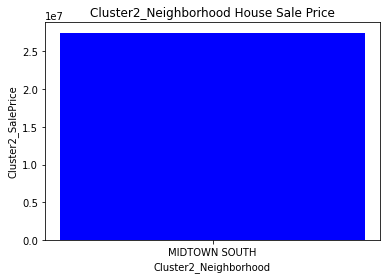

The average price of the house in Cluster 2 region : $ 27478223.53


In [43]:
Cluster2_Neighborhood = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 1]['Neighborhood']
Cluster2_SalePrice = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 1]['SALE PRICE']

x = np.arange(len(Cluster2_Neighborhood))
plt.bar(x, Cluster2_SalePrice, color=['blue'])
plt.xticks(x, Cluster2_Neighborhood)
plt.xlabel('Cluster2_Neighborhood')
plt.ylabel('Cluster2_SalePrice')
plt.title('Cluster2_Neighborhood House Sale Price')
plt.show()

print("The average price of the house in Cluster 2 region : $" , round(Cluster2_SalePrice.mean(),2))

***Cluster 3***

In [30]:
nyc_cluster_3_df = nyc_merged2[nyc_merged2['Cluster Labels'] == 2].reset_index(drop = True)
nyc_cluster_3_df.head()

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Staten Island   Bloomfield  40.605779 -74.187256             2.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    Italian Restaurant                 Hotel           Video Store   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0         Deli / Bodega           Candy Store     Recreation Center   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Theme Park       Thai Restaurant     Accessories Store   

  10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0               Pie Shop         Picnic Shelter               Pharmacy   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0              Pet Store    Peruvian Restaurant     Persian Restaurant   

  16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
0                   Park  Performing Arts Venue         Pilates Studio   

          19th Most Common Venue 20th Most Common Venue  
0  Paper / Office Supplies Store        Paintball Field

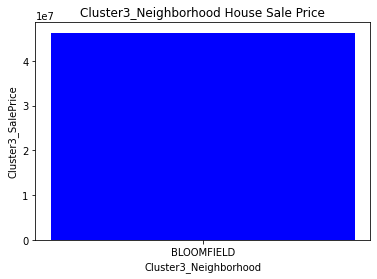

The average price of the house in Cluster 3 region : $ 46253000.0


In [44]:
Cluster3_Neighborhood = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 2]['Neighborhood']
Cluster3_SalePrice = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 2]['SALE PRICE']

x = np.arange(len(Cluster3_Neighborhood))
plt.bar(x, Cluster3_SalePrice, color=['blue'])
plt.xticks(x, Cluster3_Neighborhood)
plt.xlabel('Cluster3_Neighborhood')
plt.ylabel('Cluster3_SalePrice')
plt.title('Cluster3_Neighborhood House Sale Price')
plt.show()

print("The average price of the house in Cluster 3 region : $" , round(Cluster3_SalePrice.mean(),2))

***Cluster 4***

In [31]:
nyc_cluster_4_df = nyc_merged2[nyc_merged2['Cluster Labels'] == 3].reset_index(drop = True)
nyc_cluster_4_df.head()

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
0     Bronx  University Heights  40.855727 -73.910416             3.0   
1     Bronx             Fordham  40.860997 -73.896427             3.0   
2     Bronx          Mott Haven  40.806239 -73.916100             3.0   
3     Bronx         Port Morris  40.801664 -73.913221             3.0   
4  Brooklyn    Brooklyn Heights  40.695864 -73.993782             3.0   

       1st Most Common Venue 2nd Most Common Venue      3rd Most Common Venue  \
0  Latin American Restaurant     Accessories Store      Performing Arts Venue   
1                      Diner    Mexican Restaurant  Latin American Restaurant   
2        Peruvian Restaurant          Cocktail Bar                Coffee Shop   
3                    Brewery        Animal Shelter    New American Restaurant   
4                  Juice Bar                Garden               Cycle Studio   

  4th Most Common Venue 5th Most Common Venue  6th Most Common Venue  \
0        Pilates Studio                  Pier               Pie Shop   
1                  Café        History Museum      Accessories Store   
2           Pizza Place            Restaurant               Beer Bar   
3          Tennis Court                   Gym  Performing Arts Venue   
4        Scenic Lookout                Bakery     Persian Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0        Picnic Shelter              Pharmacy             Pet Store   
1             Pet Store           Pizza Place        Pilates Studio   
2        Pilates Studio                  Pier              Pie Shop   
3                  Pier              Pie Shop        Picnic Shelter   
4        Pilates Studio                  Pier              Pie Shop   

  10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0    Peruvian Restaurant     Persian Restaurant                   Park   
1                   Pier               Pie Shop         Picnic Shelter   
2         Picnic Shelter               Pharmacy              Pet Store   
3               Pharmacy              Pet Store    Peruvian Restaurant   
4         Picnic Shelter               Pharmacy              Pet Store   

  13th Most Common Venue         14th Most Common Venue  \
0            Planetarium  Paper / Office Supplies Store   
1               Pharmacy             Persian Restaurant   
2     Persian Restaurant                     Playground   
3     Persian Restaurant  Paper / Office Supplies Store   
4    Peruvian Restaurant                           Park   

  15th Most Common Venue 16th Most Common Venue  \
0        Paintball Field      Paella Restaurant   
1    Peruvian Restaurant             Playground   
2  Performing Arts Venue                   Park   
3                   Park            Pizza Place   
4  Performing Arts Venue            Planetarium   

          17th Most Common Venue 18th Most Common Venue  \
0          Outdoors & Recreation      Outdoor Sculpture   
1          Performing Arts Venue                   Park   
2  Paper / Office Supplies Store        Paintball Field   
3                Paintball Field      Paella Restaurant   
4  Paper / Office Supplies Store        Paintball Field   

          19th Most Common Venue 20th Most Common Venue  
0            Outdoor Event Space      Other Repair Shop  
1  Paper / Office Supplies Store        Paintball Field  
2              Paella Restaurant  Outdoors & Recreation  
3          Outdoors & Recreation      Outdoor Sculpture  
4              Paella Restaurant  Outdoors & Recreation

In [45]:
Cluster4_Neighborhood = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 3]['Neighborhood']
Cluster4_SalePrice = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 3]['SALE PRICE']

x = np.arange(len(Cluster4_Neighborhood))
plt.bar(x, Cluster4_SalePrice, color=['blue'])
plt.xticks(x, Cluster4_Neighborhood)
plt.xlabel('Cluster4_Neighborhood')
plt.ylabel('Cluster4_SalePrice')
plt.title('Cluster4_Neighborhood House Sale Price')
plt.show()

print("The average price of the house in Cluster 4 region : $" , round(Cluster4_SalePrice.mean(),2))

The average price of the house in Cluster 4 region : $ 2374434.51


***Cluster 5***

In [32]:
nyc_cluster_5_df = nyc_merged2[nyc_merged2['Cluster Labels'] == 4].reset_index(drop = True)
nyc_cluster_5_df.head()

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Manhattan        Little Italy  40.719324 -73.997305             4.0   
1  Manhattan  Financial District  40.707107 -74.010665             4.0   
2  Manhattan        Civic Center  40.715229 -74.005415             4.0   

      1st Most Common Venue   2nd Most Common Venue 3rd Most Common Venue  \
0  Mediterranean Restaurant         Thai Restaurant                Garden   
1               Coffee Shop              Restaurant     Accessories Store   
2             Jewelry Store  Furniture / Home Store                   Spa   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0    Italian Restaurant              Wine Bar        Chocolate Shop   
1    Persian Restaurant        Pilates Studio                  Pier   
2                 Hotel             Hotel Bar    Persian Restaurant   

           7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0  Paper / Office Supplies Store                 Hotel     Accessories Store   
1                       Pie Shop        Picnic Shelter              Pharmacy   
2                           Pier              Pie Shop        Picnic Shelter   

  10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0               Pie Shop         Picnic Shelter               Pharmacy   
1              Pet Store    Peruvian Restaurant  Performing Arts Venue   
2               Pharmacy              Pet Store    Peruvian Restaurant   

  13th Most Common Venue 14th Most Common Venue  \
0              Pet Store    Peruvian Restaurant   
1            Planetarium                   Park   
2  Performing Arts Venue            Pizza Place   

          15th Most Common Venue         16th Most Common Venue  \
0                           Park             Persian Restaurant   
1  Paper / Office Supplies Store                Paintball Field   
2                           Park  Paper / Office Supplies Store   

  17th Most Common Venue 18th Most Common Venue 19th Most Common Venue  \
0  Performing Arts Venue         Pilates Studio        Paintball Field   
1      Paella Restaurant  Outdoors & Recreation      Outdoor Sculpture   
2        Paintball Field      Paella Restaurant  Outdoors & Recreation   

  20th Most Common Venue  
0      Paella Restaurant  
1    Outdoor Event Space  
2      Outdoor Sculpture

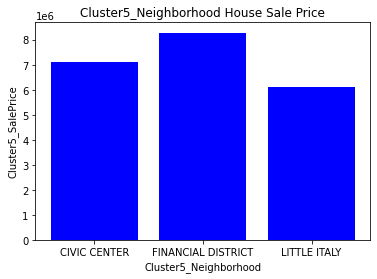

The average price of the house in Cluster 5 region : $ 7161361.98


In [46]:
Cluster5_Neighborhood = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 4]['Neighborhood']
Cluster5_SalePrice = neighborhoods_venues_sorted_house_price[neighborhoods_venues_sorted_house_price['Cluster Labels'] == 4]['SALE PRICE']

x = np.arange(len(Cluster5_Neighborhood))
plt.bar(x, Cluster5_SalePrice, color=['blue'])
plt.xticks(x, Cluster5_Neighborhood)
plt.xlabel('Cluster5_Neighborhood')
plt.ylabel('Cluster5_SalePrice')
plt.title('Cluster5_Neighborhood House Sale Price')
plt.show()

print("The average price of the house in Cluster 5 region : $" , round(Cluster5_SalePrice.mean(),2))

### 5) Results and Conclusion

According to the above analysis, we can conclude that Neighborhoods in Cluster 1 are probably residential areas, since the average house price is the lowest among clusters and it consists of restaurants, shops, and stores. We can highly recommend our immigrant customers to live in Cluster 1. For Cluster 2 and 3, the top 2 highest house price in New York City, where hotels and entertainment venues mostly locate, probably we can see lots of people from different states and countries in these 2 areas. Neighborhoods in Cluster 4 mostly locate in Manhattan and also consist of restaurants, shops, and stores. We could also recommend our immigrant customers to live in Cluster 4 if our customers have more budget on either renting or purchasing their house. Neighborhoods in Cluster 5 are probably the CBD (Central Business District), since the cluster consists of luxurious venues, such as jewelry stores, hotels and bars. <br><br>

The purpose of this problem is to explore a city in a glimpse, and also in a scientific way. We can even discover that the house sale price might be also related with the composition of the clusters. All in all, now it's up to how our immigrant customers choice on where to reside.

---------------------------------------------------------------------------------------------------------------------------------------------------------------

## Part B. Time-constrained Tourists Problem - Visiting as many top attractions as possible in 3 days

### 1) Data Collection - Download and Explore Dataset

Assuming the tourists live in somewhere around Lincoln Square, let's get the top 100 venues that are in Lincoln Square within a radius of 10 kilometers.

In [48]:
LIMIT = 100
radius = 10000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    float(neighborhoods['Latitude'][neighborhoods['Neighborhood'] == 'Lincoln Square']), # lat of Lincoln Square
    float(neighborhoods['Longitude'][neighborhoods['Neighborhood'] == 'Lincoln Square']), # lon of Lincoln Square
    radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=FOP4YBIEWZ5G4MN5CPVLIWCDQ0HXESG5TWMDQJUREZRE12YC&client_secret=DGMSCBDBOEGO4S3K5I3P4NYECUE1QYR5OFFUQJB0JBL2OWZO&v=20180605&ll=40.77352888942166,-73.98533777001262&radius=10000&limit=100'

In [49]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60f034fca4bf057a74b05d40'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'New York',
  'headerFullLocation': 'New York',
  'headerLocationGranularity': 'city',
  'totalResults': 239,
  'suggestedBounds': {'ne': {'lat': 40.86352897942175,
    'lng': -73.86671579463055},
   'sw': {'lat': 40.68352879942157, 'lng': -74.10395974539469}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '48e480eef964a52022521fe3',
       'name': 'The Metropolitan Opera (Metropolitan Opera)',
       'location': {'address': '70 Lincoln Center Plz',
        'crossStreet': 'at Columbus Ave',
        'lat': 40.77274188001071,
       

In [50]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [69]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


name  \
0         The Metropolitan Opera (Metropolitan Opera)   
1              Lincoln Center for the Performing Arts   
2                                Riverside Park South   
3                                      NYRR RUNCenter   
4                                               Marea   
5                                       Levain Bakery   
6                                   Bethesda Fountain   
7                                    Bethesda Terrace   
8                                    Gershwin Theatre   
9                                                TMPL   
10                           Equinox West 50th Street   
11                           Central Park - Wien Walk   
12                              Winter Garden Theatre   
13                                 Shakespeare Garden   
14                        Museum of Modern Art (MoMA)   
15                                      Saint Laurent   
16                                  Delacorte Theater   
17                              Radio City Music Hall   
18                                  Jim's Shoe Repair   
19                   Top of the Rock Observation Deck   
20                                  Central Park Loop   
21                           Riverside Park Promenade   
22                                   Majestic Theatre   
23                            St. Patrick's Cathedral   
24                                    Los Tacos No. 1   
25                                          Albertine   
26                                 Park Avenue Armory   
27                           Equinox East 63rd Street   
28                                       Central Park   
29                      Central Park West - W 86th St   
30  The Metropolitan Museum of Art (Metropolitan M...   
31                                Greek and Roman Art   
32                                          PlantShed   
33                          Metropolitan Museum Steps   
34                                   Temple of Dendur   
35                                           Boqueria   
36                                   Books Kinokuniya   
37                                        Bryant Park   
38                                   Barry's Bootcamp   
39               Jacqueline Kennedy Onassis Reservoir   
40                    New York Public Library Terrace   
41                                               MUJI   
42                           Equinox East 61st Street   
43                                      Levain Bakery   
44                                                 NR   
45                                SoulCycle East 83rd   
46                                       Anita Gelato   
47                                  The Jewish Museum   
48                                   Schaller & Weber   
49                                         Jongro BBQ   
50                                      City Swiggers   
51                             Kitchen Arts & Letters   
52                                        East Meadow   
53                           Equinox East 92nd Street   
54                                        Body & Pole   
55                                   Gagosian Gallery   
56                                     Dulce de Leche   
57                          Pier 63 Hudson River Park   
58                                          High Line   
59         West 105th Street Dog Run - Riverside Park   
60                                            Peloton   
61                                Madison Square Park   
62                                        Kalustyan's   
63                                   Carl Schurz Park   
64                              David Zwirner Gallery   
65                                Conservatory Garden   
66                                    Eataly Flatiron   
67                            Gantry Plaza State Park   
68                    High Line 10th Ave Amphitheatre   
69                                     SoulCycle 19th   
70

### 2) Data Processing - Data Cleaning and Wrangling

Since the tourists have little of time to explore the city, we will filter worthy attractions for them

In [70]:
major_sightseeing_spots = ['Opera House', 'Performing Arts Venue', 'Park','Fountain', 'Plaza', 'Theater','Garden', 'Art Museum', 'Concert Hall','Scenic Lookout', 'Waterfront', 'Church','Exhibit', 'Reservoir','Museum',  'Field', 'Art Gallery', 'Market']

major_sightseeing_venues = nearby_venues[nearby_venues['categories'].isin(major_sightseeing_spots)]
major_sightseeing_venues = major_sightseeing_venues.reset_index(drop = True)
major_sightseeing_venues

name             categories  \
0         The Metropolitan Opera (Metropolitan Opera)            Opera House   
1              Lincoln Center for the Performing Arts  Performing Arts Venue   
2                                Riverside Park South                   Park   
3                                   Bethesda Fountain               Fountain   
4                                    Bethesda Terrace                  Plaza   
5                                    Gershwin Theatre                Theater   
6                            Central Park - Wien Walk                   Park   
7                               Winter Garden Theatre                Theater   
8                                  Shakespeare Garden                 Garden   
9                         Museum of Modern Art (MoMA)             Art Museum   
10                                  Delacorte Theater                Theater   
11                              Radio City Music Hall           Concert Hall   
12                   Top of the Rock Observation Deck         Scenic Lookout   
13                           Riverside Park Promenade             Waterfront   
14                                   Majestic Theatre                Theater   
15                            St. Patrick's Cathedral                 Church   
16                                       Central Park                   Park   
17                      Central Park West - W 86th St                   Park   
18  The Metropolitan Museum of Art (Metropolitan M...             Art Museum   
19                                Greek and Roman Art                Exhibit   
20                          Metropolitan Museum Steps                  Plaza   
21                                   Temple of Dendur                Exhibit   
22                                        Bryant Park                   Park   
23               Jacqueline Kennedy Onassis Reservoir              Reservoir   
24                    New York Public Library Terrace                  Plaza   
25                                  The Jewish Museum                 Museum   
26                                        East Meadow                  Field   
27                                   Gagosian Gallery            Art Gallery   
28                          Pier 63 Hudson River Park                   Park   
29                                          High Line                   Park   
30                                Madison Square Park                   Park   
31                                   Carl Schurz Park                   Park   
32                              David Zwirner Gallery            Art Gallery   
33                                Conservatory Garden                 Garden   
34                    High Line 10th Ave Amphitheatre         Scenic Lookout   
35                                     Riverside Park                   Park   
36                          Hunter's Point South Park                   Park   
37                                     Chelsea Market                 Market   

          lat        lng  
0   40.772742 -73.984401  
1   40.772282 -73.982948  
2   40.778324 -73.989111  
3   40.774294 -73.970840  
4   40.773854 -73.970982  
5   40.762298 -73.985160  
6   40.766566 -73.972254  
7   40.761405 -73.983555  
8   40.779810 -73.969955  
9   40.761412 -73.977462  
10  40.780265 -73.968780  
11  40.759850 -73.979344  
12  40.759095 -73.979352  
13  40.788762 -73.982914  
14  40.758268 -73.988107  
15  40.758627 -73.976398  
16  40.783076 -73.965497  
17  40.785094 -73.969134  
18  40.779729 -73.963416  
19  40.778174 -73.963529  
20  40.779063 -73.962514  
21  40.780411 -73.962675  
22  40.753621 -73.983265  
23  40.785021 -73.962516  
24  40.753017 -73.981480  
25  40.785276 -73.957411  
26  40.790160 -73.955498  
27  40.749493 -74.006050  
28  40.749500 -74.008595  
29  40.746825 -74.005507  
30  40.742262 -73.988006  
31  40.775118 -73.943763  
32  40.746635 -74.007329  
33  40.793

### 3) Clustering - Applying DBSCAN Machine Learning Algorithm

In [71]:
# Apply DBSCAN Algorithm
X = major_sightseeing_venues[['lat','lng']]
clustering = DBSCAN(eps=0.005,min_samples=3).fit(X)

# add clustering labels
major_sightseeing_venues.insert(0, 'Cluster Labels', clustering.labels_)
cluster_num = len(major_sightseeing_venues['Cluster Labels'].unique())

# create map
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(cluster_num)
ys = [i + x + (i*x)**2 for i in range(cluster_num)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(major_sightseeing_venues['lat'], major_sightseeing_venues['lng'], major_sightseeing_venues['name'], major_sightseeing_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

Looks like *Cluster 0* has been excluded, since the attractions are too far away from the others 

In [73]:
final_sightseeing_venues = major_sightseeing_venues[major_sightseeing_venues['Cluster Labels'] > -1] # Cluster number -1 is actually equivalent to Cluster 0, the tag name changes when creating folium map
final_sightseeing_venues = final_sightseeing_venues.reset_index(drop = True)
final_sightseeing_venues

Cluster Labels                                               name  \
0                0                                   Gershwin Theatre   
1                0                              Winter Garden Theatre   
2                1                                 Shakespeare Garden   
3                0                        Museum of Modern Art (MoMA)   
4                1                                  Delacorte Theater   
5                0                              Radio City Music Hall   
6                0                   Top of the Rock Observation Deck   
7                0                                   Majestic Theatre   
8                0                            St. Patrick's Cathedral   
9                1                                       Central Park   
10               1                      Central Park West - W 86th St   
11               1  The Metropolitan Museum of Art (Metropolitan M...   
12               1                                Greek and Roman Art   
13               1                          Metropolitan Museum Steps   
14               1                                   Temple of Dendur   
15               1               Jacqueline Kennedy Onassis Reservoir   
16               2                                   Gagosian Gallery   
17               2                          Pier 63 Hudson River Park   
18               2                                          High Line   
19               2                              David Zwirner Gallery   
20               2                    High Line 10th Ave Amphitheatre   
21               2                                     Chelsea Market   

        categories        lat        lng  
0          Theater  40.762298 -73.985160  
1          Theater  40.761405 -73.983555  
2           Garden  40.779810 -73.969955  
3       Art Museum  40.761412 -73.977462  
4          Theater  40.780265 -73.968780  
5     Concert Hall  40.759850 -73.979344  
6   Scenic Lookout  40.759095 -73.979352  
7          Theater  40.758268 -73.988107  
8           Church  40.758627 -73.976398  
9             Park  40.783076 -73.965497  
10            Park  40.785094 -73.969134  
11      Art Museum  40.779729 -73.963416  
12         Exhibit  40.778174 -73.963529  
13           Plaza  40.779063 -73.962514  
14         Exhibit  40.780411 -73.962675  
15       Reservoir  40.785021 -73.962516  
16     Art Gallery  40.749493 -74.006050  
17            Park  40.749500 -74.008595  
18            Park  40.746825 -74.005507  
19     Art Gallery  40.746635 -74.007329  
20  Scenic Lookout  40.743981 -74.006844  
21          Market  40.742063 -74.006127

In [103]:
# Separate the Clusters
final_sightseeing_venues_cluster1 = final_sightseeing_venues[final_sightseeing_venues['Cluster Labels'] == 0]
final_sightseeing_venues_cluster2 = final_sightseeing_venues[final_sightseeing_venues['Cluster Labels'] == 1]
final_sightseeing_venues_cluster3 = final_sightseeing_venues[final_sightseeing_venues['Cluster Labels'] == 2]

final_sightseeing_venues_cluster1 = final_sightseeing_venues_cluster1.reset_index(drop = True)
final_sightseeing_venues_cluster2 = final_sightseeing_venues_cluster2.reset_index(drop = True)
final_sightseeing_venues_cluster3 = final_sightseeing_venues_cluster3.reset_index(drop = True)

# Add Depot data
depot1 = {'Cluster Labels':0, 'name':'Lincoln Square', 'categories':'depot', 'lat': nyc_merged[nyc_merged['Neighborhood'] == 'Lincoln Square']['Latitude'] ,'lng':nyc_merged[nyc_merged['Neighborhood'] == 'Lincoln Square']['Longitude'] }
depot1 = pd.DataFrame.from_dict(depot1)
depot2 = {'Cluster Labels':1, 'name':'Lincoln Square', 'categories':'depot', 'lat': nyc_merged[nyc_merged['Neighborhood'] == 'Lincoln Square']['Latitude'] ,'lng':nyc_merged[nyc_merged['Neighborhood'] == 'Lincoln Square']['Longitude'] }
depot2 = pd.DataFrame.from_dict(depot2)
depot3 = {'Cluster Labels':2, 'name':'Lincoln Square', 'categories':'depot', 'lat': nyc_merged[nyc_merged['Neighborhood'] == 'Lincoln Square']['Latitude'] ,'lng':nyc_merged[nyc_merged['Neighborhood'] == 'Lincoln Square']['Longitude'] }
depot3 = pd.DataFrame.from_dict(depot3)

# Merge Depot data with Cluster data
final_sightseeing_venues_cluster1 = pd.concat([depot1,final_sightseeing_venues_cluster1])
final_sightseeing_venues_cluster2 = pd.concat([depot2,final_sightseeing_venues_cluster2])
final_sightseeing_venues_cluster3 = pd.concat([depot3,final_sightseeing_venues_cluster3])

final_sightseeing_venues_cluster1 = final_sightseeing_venues_cluster1.reset_index(drop = True)
final_sightseeing_venues_cluster2 = final_sightseeing_venues_cluster2.reset_index(drop = True)
final_sightseeing_venues_cluster3 = final_sightseeing_venues_cluster3.reset_index(drop = True)

### 4) Routing - Applying Google OR-Tools : Traveling Salesperson Problem

Reference: https://developers.google.com/optimization/routing/tsp 

In [115]:
sightseeing_cluster = [final_sightseeing_venues_cluster1, final_sightseeing_venues_cluster2, final_sightseeing_venues_cluster3]

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


for k in sightseeing_cluster:

    def build_distance_matrix(dff):
        """Distance matrix: Calculate the distance between venue and venue"""
        
        dff['distance_matrix'] = ''
        for i in range(0,len(dff)):
            distance_matrix = []
            for j in range(0,len(dff)):
                distance_matrix.append(int(round((math.sqrt(pow(float(dff['lat'][i])-float(dff['lat'][j]),2) + pow(float(dff['lng'][i])-float(dff['lng'][j]),2))*111320))))
            dff['distance_matrix'][i] = distance_matrix
        return list(dff['distance_matrix'])

    def create_data_model():
        """Stores the data for the problem."""
        data = {}
        data['distance_matrix'] = build_distance_matrix(k)
        data['num_vehicles'] = 1
        data['depot'] = 0
        data['name'] =list(k['name'])
        return data

    def print_solution(data, manager, routing, solution):
        """Prints solution on console."""
        print('Objective Trip Distance: {} miles'.format(solution.ObjectiveValue()))
        index = routing.Start(0)
        plan_output = 'Route Order for Trip Cluster:\n'
        route_distance = 0
        
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            plan_output += str(data['name'][manager.IndexToNode(index)]) + ' -> '
            
            previous_index = index
            
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        
        plan_output += ' {}\n'.format(manager.IndexToNode(index))
        
        print(plan_output)
        plan_output += 'Route distance: {}miles\n'.format(route_distance)


    def main():
        """Entry point of the program."""
        # Instantiate the data problem.
        data = create_data_model()

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)


        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)

        # Print solution on console.
        if solution:
            print_solution(data, manager, routing, solution)


    if __name__ == '__main__':
        main()
        

Objective Trip Distance: 5279 miles
Route Order for Trip Cluster:
Lincoln Square -> Museum of Modern Art (MoMA) -> St. Patrick's Cathedral -> Top of the Rock Observation Deck -> Radio City Music Hall -> Winter Garden Theatre -> Majestic Theatre -> Gershwin Theatre ->  0

Objective Trip Distance: 6594 miles
Route Order for Trip Cluster:
Lincoln Square -> Shakespeare Garden -> Delacorte Theater -> Greek and Roman Art -> Metropolitan Museum Steps -> The Metropolitan Museum of Art (Metropolitan Museum of Art) -> Temple of Dendur -> Jacqueline Kennedy Onassis Reservoir -> Central Park -> Central Park West - W 86th St ->  0

Objective Trip Distance: 8952 miles
Route Order for Trip Cluster:
Lincoln Square -> Gagosian Gallery -> Pier 63 Hudson River Park -> David Zwirner Gallery -> High Line 10th Ave Amphitheatre -> Chelsea Market -> High Line ->  0



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 5) Results and Conclusion

Finally, we come out with the trip detail and visit order for these 3 days, now we are able to make tour arrangements for our time-constrained customers. <br><br>

**Day 1** <br>
<li> Start from "Lincoln Square", and first we will visit "Museum of Modern Art (MoMA)"</li>
<li> After that, we will visit "St. Patrick's Cathedral".</li>
<li> Then, we will go to "Top of the Rock Observation Deck" and have lunch nearby.</li>
<li> After lunch, we will go to "Radio City Music Hall". </li>
<li> Then, we will go to "Winter Garden Theatre" and "Majestic Theatre".</li>
<li> Then, we will enjoy a show at "Gershwin Theatre".</li>
<li> Finally, let's have some food and drinks in the bars nearby.    </li>
<br>

**Day 2** <br>
<li> First of all, we will go to "Shakespeare Garden" and "Delacorte Theater". </li>
<li> After that, we will visit The "Metropolitan Museum of Art (Metropolitan Museum of Art)" and have lunch nearby. </li>
<li> After lunch, we will visit "Temple of Dendur". </li>
<li> Then, we will go to "Jacqueline Kennedy Onassis Reservoir" and "Central Park". </li>
<li> Finally, let's shop nearby. </li>
<br>

**Day 3** <br>
<li> First of all, we will visit "Gagosian Gallery". </li>
<li> After that, we will go to "Pier 63 Hudson River Park" and have lunch nearby. </li>
<li> After lunch, we will visit "David Zwirner Gallery". </li>
<li> Then, we will go to "High Line 10th Ave Amphitheatre" and "Chelsea Market". </li>
<li> Finally, let's go to "High Line" for our last stop in New York City. Enjoy the skyline of New York City! </li>
<br>
<br>
The purpose of this problem is to help foreign travellers (especially for those who have never been to New York City before (like ME)) to quickly arrange the visiting order of the top attractions in a scientific and reasonable way.